# PBMC T cells Analysis
## Xiaonan Wang
## 11Aug2020

Analysis of T cells in 3 PBMC samples.

In [21]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import anndata

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [ ]:
import sys
sys.path.append('./source_code/')
from CarT_source_code import *

In [13]:
adata = sc.read('./write/PBMC_Tcells.h5ad')

In [3]:
adata = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
adata.raw = adata

In [4]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.5, batch_key='batch', inplace=True)

extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


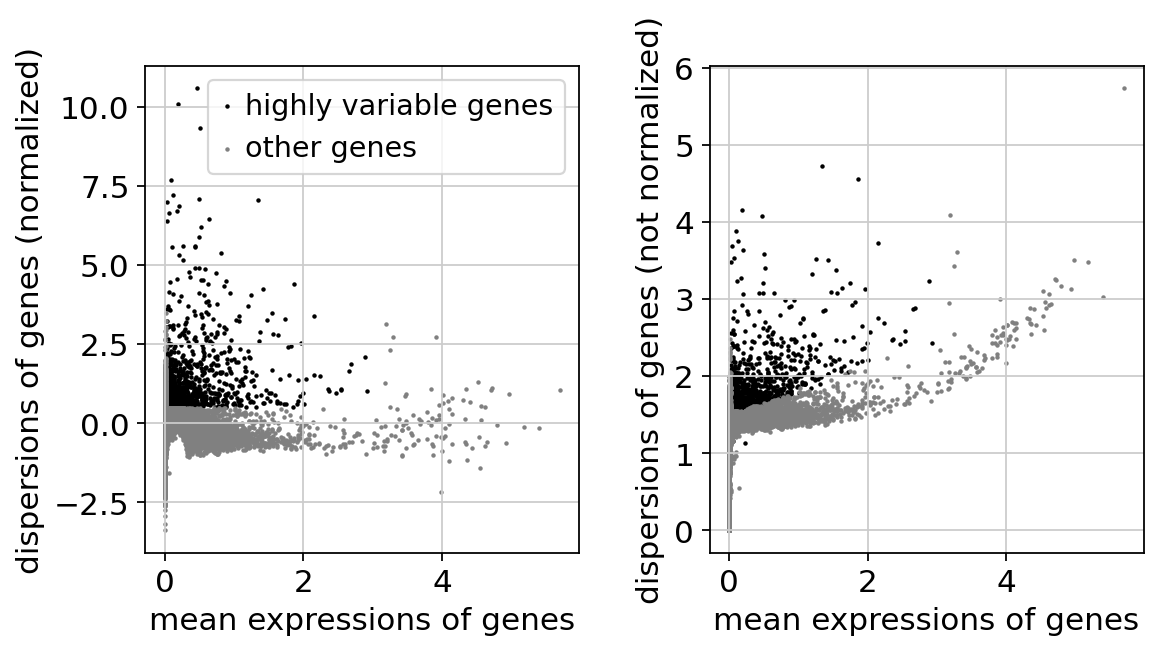

In [5]:
sc.pl.highly_variable_genes(adata)

In [6]:
print(np.sum(adata.var.highly_variable))

1732


In [7]:
adata = adata[:, adata.var.highly_variable]

In [8]:
adata.shape

(10845, 1732)

In [9]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'])

regressing out ['total_counts', 'pct_counts_mt', 'n_genes_by_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


In [10]:
# scale for pca
sc.pp.scale(adata)

In [11]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(10845, 1732)
Donor1    3693
Donor2    3763
Donor3    3389
Name: Donor, dtype: int64


# Visualisation

In [12]:
# first try pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


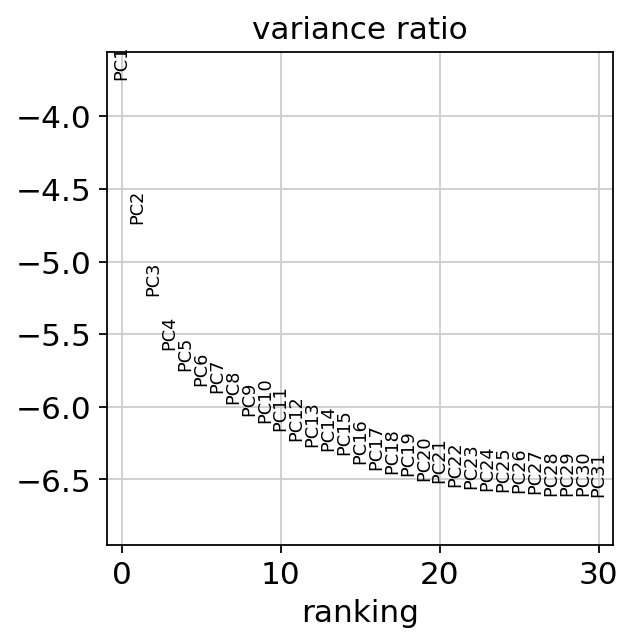

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:32)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:42)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.97724307 0.9642266  0.9424479  0.9349597  0.9272583
     0.92124224 0.91468745 0.9018487  0.89989793 0.8946628  0.8871907
     0.8859184  0.88275844 0.8611694 ]
    finished: added
    'X_diffmap', diffmap coordinates (

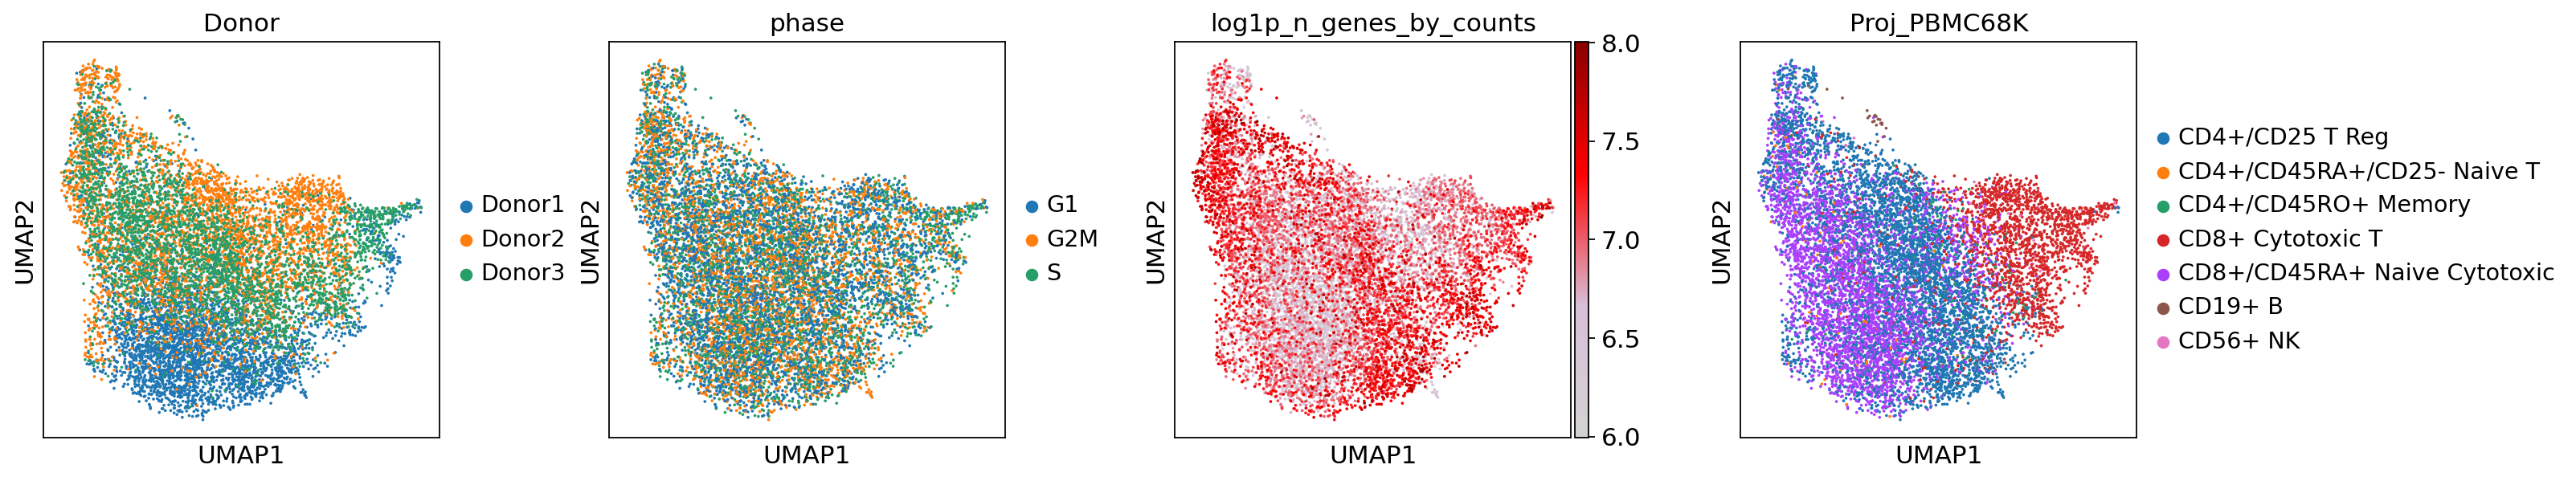

In [15]:
sc.pl.umap(adata, color=['Donor', 'phase', 'log1p_n_genes_by_counts', 'Proj_PBMC68K'], color_map=cmap, wspace=0.3)

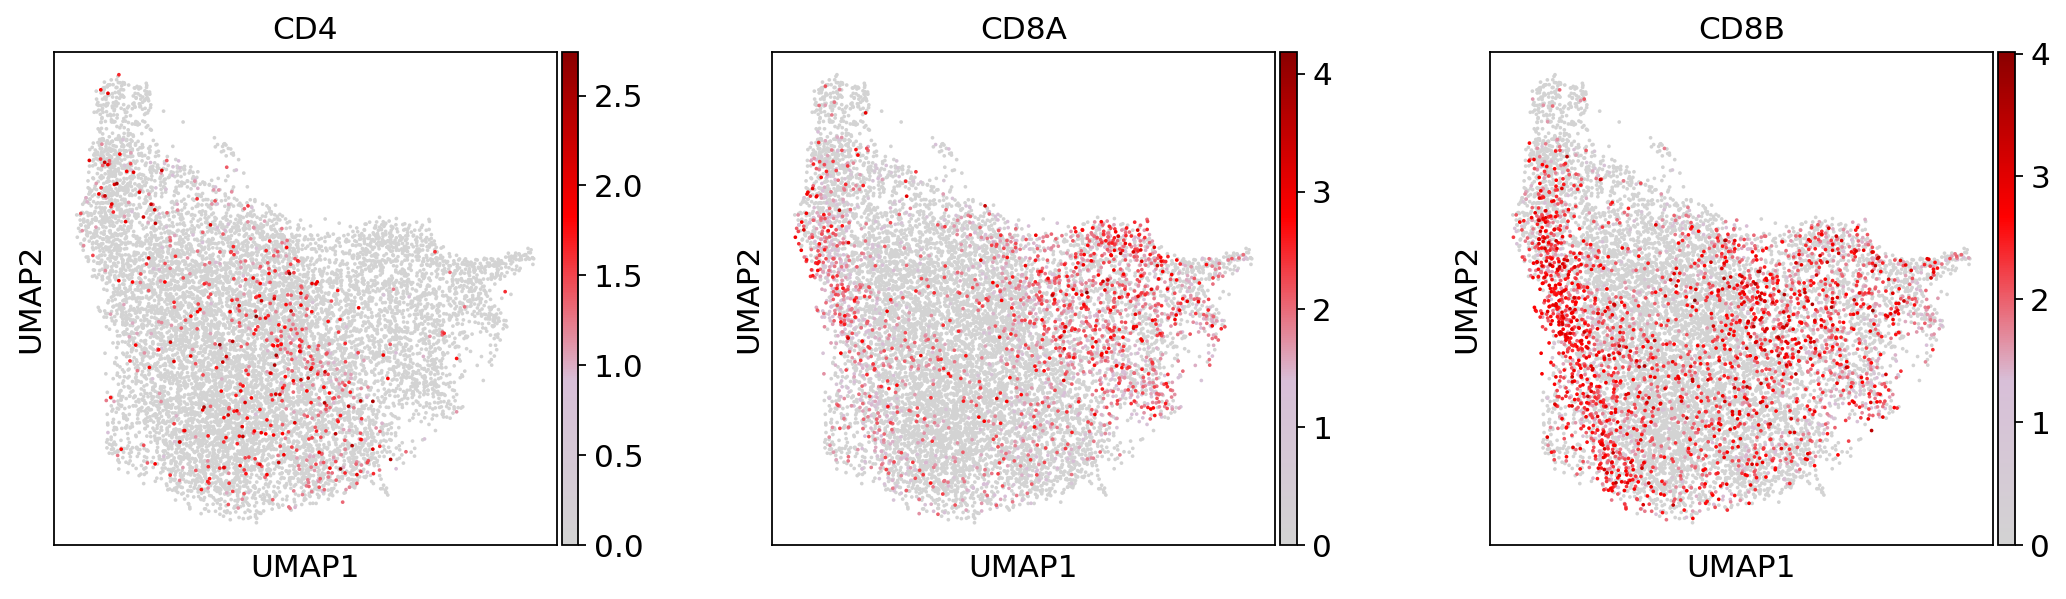

In [16]:
sc.pl.umap(adata, color=['CD4', 'CD8A', 'CD8B'], color_map=cmap, wspace=0.3)

In [19]:
adata.obs['CD8'] = np.mean(adata.raw[:, ['CD8A', 'CD8B']].X.toarray(), axis=1)

In [25]:
adata.obs['CD8_Assign'] = ['CD8+' if x>0 else 'CD8-' for x in adata.obs['CD8'].values]

... storing 'CD8_Assign' as categorical


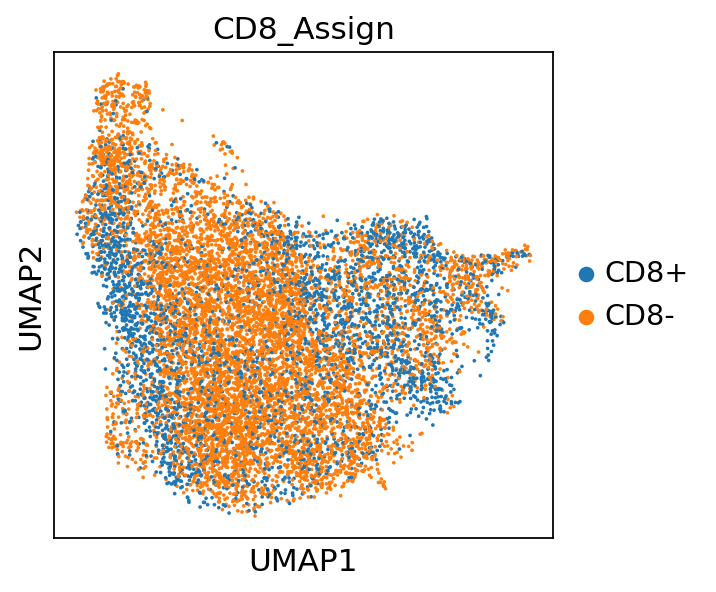

In [26]:
sc.pl.umap(adata, color=['CD8_Assign'], color_map=cmap)

In [20]:
adata.write('./write/PBMC_Tcells_processed.h5ad')

In [15]:
adata = sc.read('./write/PBMC_Tcells_processed.h5ad')

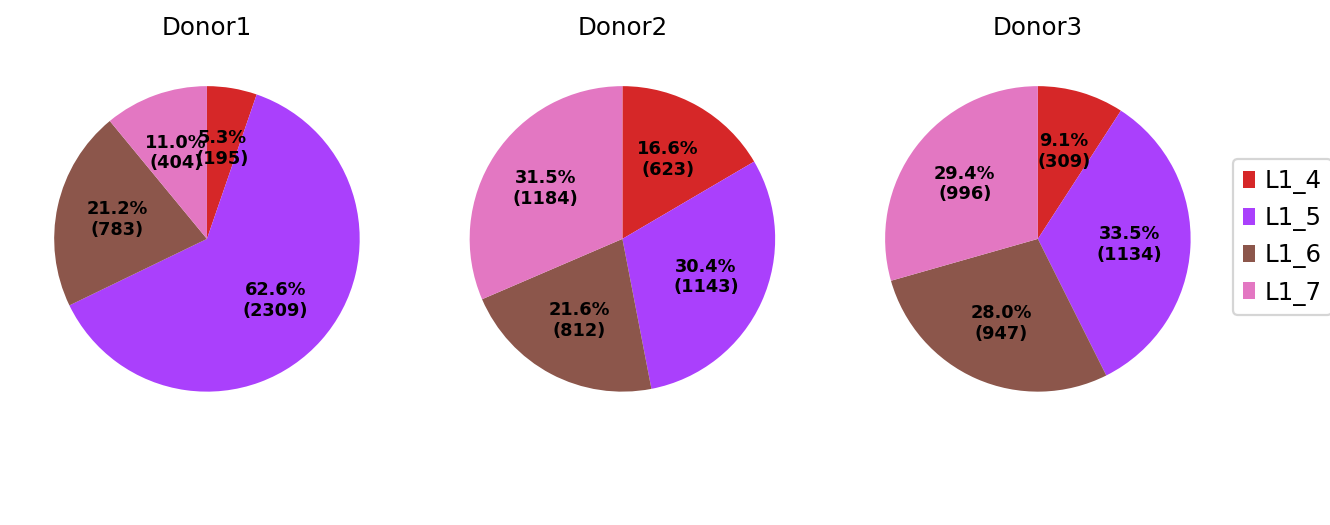

In [23]:
FN = 'PBMC_Tcells_louvainv1_donor_pie'
df = lv_stat_barplot(adata, fontsize=11, splitby="Donor", colorby="louvain_v1", plotMethod="PieChart", color=adata.uns['louvain_v1_colors'],  save=FN+'.pdf', figsize=(8,6), bbox_to_anchor=(1.05,0.3))
df.to_csv('./table/'+FN+'.csv')

# Double Check

In [28]:
adata = sc.read('./write/PBMC_Tcells_processed.h5ad')

In [29]:
print(adata.shape)

(10845, 1732)


In [33]:
adata.obs['Donor'].value_counts().sort_index()

Donor1    3693
Donor2    3763
Donor3    3389
Name: Donor, dtype: int64